<a href="https://colab.research.google.com/github/park-geun-hyeong/AI_service_from_youtube/blob/main/TorchVision(keypoints_Detection%2C%20Segmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import seaborn as sns

import time
import os
from tqdm import tqdm
import glob

from PIL import Image
import cv2

In [2]:
print(torchvision.__version__)

0.9.0+cu101


## TorchVision_keypoints

In [12]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True).eval()

In [ ]:
img_size=460
threshgold=0.95

img_path = '/content/drive/MyDrive/Youtube/TorchVision/stand_image2.jpg'

img = Image.open(img_path)
img = img.resize((img_size, int(img.height*img_size/img.width)))

plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

In [30]:
import torchvision.transforms as T

trf = T.Compose([T.ToTensor()])

input_img = trf(img)

In [31]:
input_img.shape

torch.Size([3, 338, 460])

In [32]:
out = model([input_img])[0]

In [33]:
print(out.keys())

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])


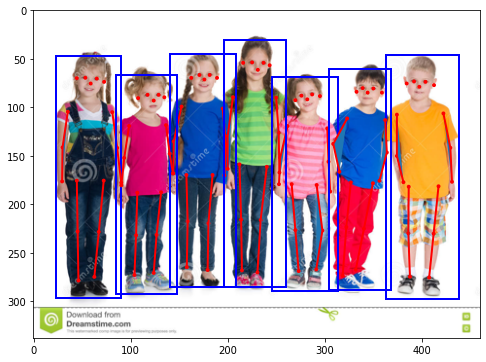

In [61]:
codes=[ Path.MOVETO, Path.LINETO, Path.LINETO]

fig, ax = plt.subplots(1, figsize=(8,8))

ax.imshow(img)
 

for boxes, scores, keypoints in zip(out['boxes'], out['scores'], out['keypoints']):
    scores = scores.detach().numpy()

    if scores < threshgold:
        continue

    box = boxes.detach().numpy()
    keypoints = keypoints.detach().numpy()[:,:2]

    rect = patches.Rectangle((box[0],box[1]), (box[2]-box[0]), (box[3]-box[1]), linewidth=2, edgecolor='b', facecolor = None, fill=False)
    ax.add_patch(rect)

    for k in keypoints:
        circle = patches.Circle((k[0], k[1]), radius=2, facecolor='r')
        ax.add_patch(circle)

    
    path = Path(keypoints[5:10:2], codes) ## left arm
    line = patches.PathPatch(path, linewidth=2, facecolor=None, edgecolor='r')
    ax.add_patch(line)

    path = Path(keypoints[6:11:2],codes) ## right arm
    line = patches.PathPatch(path, linewidth=2, facecolor=None, edgecolor='r')
    ax.add_patch(line)

    path = Path(keypoints[11:16:2],codes) ## left leg
    line = patches.PathPatch(path, linewidth=2, facecolor=None, edgecolor='r')
    ax.add_patch(line)

    path = Path(keypoints[12:17:2],codes) ## right leg
    line = patches.PathPatch(path, linewidth=2, facecolor=None, edgecolor='r')
    ax.add_patch(line)

## TorchVision Segmentation

In [36]:
model2 = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [ ]:
img_path2 = '/content/drive/MyDrive/Youtube/TorchVision/man_with_cat.jpg'

img2 = Image.open(img_path2)

plt.figure(figsize=(10,10))
plt.imshow(img2)
plt.show()

In [44]:
trf2 = T.Compose([
                  T.Resize(img_size),
                  T.ToTensor(),
                  T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

])

input_img2 = trf2(img2).unsqueeze(0) ## add dim(4D-tensor) model이 4D tensor 호환이기때문

In [45]:
input_img2.shape

torch.Size([1, 3, 460, 766])

In [47]:
out2 = model2(input_img2)['out'] 

In [51]:
out2.shape ## batchsize, classes, img_size

torch.Size([1, 21, 460, 766])

In [52]:
out2 = torch.argmax(out2.squeeze(), dim=0) ## channel 기준으로 argmax진행하여 class 결정하기
out2 = out2.detach().cpu().numpy()

print(out2.shape)
print(np.unique(out2))

(460, 766)
[ 0  8 15]


In [53]:
COLORS = np.array([
    (0, 0, 0),       # 0=background
    (128, 0, 0),     # 1=aeroplane
    (0, 128, 0),     # 2=bicycle
    (128, 128, 0),   # 3=bird
    (0, 0, 128),     # 4=boat
    (128, 0, 128),   # 5=bottle
    (0, 128, 128),   # 6=bus
    (128, 128, 128), # 7=car
    (255, 255, 255), # 8=cat
    (192, 0, 0),     # 9=chair
    (64, 128, 0),    # 10=cow
    (192, 128, 0),   # 11=dining table
    (64, 0, 128),    # 12=dog
    (192, 0, 128),   # 13=horse
    (64, 128, 128),  # 14=motorbike
    (192, 128, 128), # 15=person
    (0, 64, 0),      # 16=potted plant
    (128, 64, 0),    # 17=sheep
    (0, 192, 0),     # 18=sofa
    (128, 192, 0),   # 19=train
    (0, 64, 128)     # 20=tv/monitor
])

In [56]:
def seg_map(img, n_classes=21):
    rgb = np.zeros((img.shape[0],img.shape[1],3), dtype=np.uint8)

    for c in range(n_classes):
        idx = img==c

        rgb[idx] = COLORS[c]

    return rgb



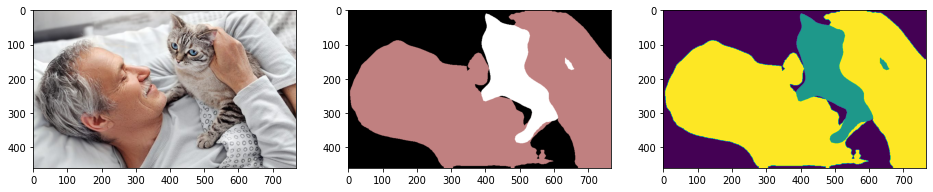

In [64]:
result = seg_map(out2)

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,12))

ax1.imshow(img2)
ax2.imshow(result)## Color 지정
ax3.imshow(out2)## 기본 segmentation

plt.show()